# Analysis of Boosting + Complexity Measures per Level of complexity

We perform

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import math


os.chdir("..")
root_path = os.getcwd()

In [2]:
path_csv = os.path.join(root_path, 'Results_Boosting')
os.chdir(path_csv)


In [3]:
#colour_palette_personalized = ["#FFD700", "#00CED1", "#FF1493","#F1F1F1"]
colour_palette_personalized = {
    "classic": "#FFD700",   # yellow
    "init_easy": "#00CED1", # blue
    "init_hard": "#FF1493",    # magenta
    "init_easy_w_complex": "#F1F1F1" ,    # grey
    "Classic": "#FFD700",   # yellow
    "Easy": "#00CED1", # blue
    "Hard": "#FF1493",    # magenta
}

In [4]:

def win_tie_loss_comparison(data, main_method, compare_method, metric='misc_rate_test_mean',
                            n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'misc_rate_test_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[data['n_ensemble'] == n]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                    elif main_value == compare_value:
                        tie += 1
                    else:
                        loss += 1

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)
    return win_tie_loss_df



We perform this analysis for all the datasets now. We read all the csv and we aggregate the results to obtain a general overview.

In [5]:
specific_path = os.path.join(path_csv, '*Aggregated*.csv')
selected_files = glob.glob(specific_path)
all_datasets = pd.concat([pd.read_csv(f) for f in selected_files], ignore_index=True)

In [6]:
all_datasets = all_datasets[all_datasets.method_weights != 'init_easy_w_complex']
all_datasets.reset_index()
all_datasets.shape

(250800, 11)

We aggregate all the results by calculating mean, median and standard deviation of exp_loss, misc_rate_train and misc_rate_test

### Analysis according to levels of complexity

In the previous analysis we cannot observe a clear gain in applying complexity measure to initialize weights in boosting. We have seen that in some cases better results are achieved but in other cases (a majority) it is better to stay with the classic weights. Besides, the classic weights require less computational cost. However, as the complexity of the datasets increase, we could observe that the init_easy weights obtain better performance. Thus, in this section we want to perform the same analysis but splitting the datasets according to their global complexity. That is, we are going to take each complexity measure and, according to its global complexity values, we are going to divide the datasets in easy and hard and see if in the hard cases, our approach reveals more profit. 

We already have the complexity characteristics of each dataset in the csv complex_info_total_dataset. We read it and split the datasets according to the complexity values of each complexity measure.

In [7]:
df_complex = pd.read_csv('complex_info_total_dataset.csv')
df_complex.head()

,dataset,Hostility,kDN,DS,DCP,TD_U,TD_P,MV,CB,CLD,N1,N2,LSC,LSradius,H,U,F1,F2,F3,F4
0,WineQualityRed_5vs6,0.238817,0.353298,0.697414,0.434605,0.526072,1.000000,0.030542,0.666312,0.439801,0.349711,0.311649,0.994867,0.863844,0.001516,0.994875,0.982080,0.687072,0.804350,0.961777
1,Yeast_CYTvsNUC,0.334081,0.413901,0.733312,0.451175,0.552192,1.000000,0.035318,0.666182,0.499548,0.413995,0.443503,0.995953,0.909363,0.002242,0.995962,0.736967,0.000000,0.714249,0.951642
2,analcatdata_authorship,0.008323,0.007848,0.326491,0.101312,0.738853,0.846017,0.170812,0.749962,0.045534,0.007841,0.434471,0.726380,0.340897,0.001762,0.728145,0.763077,0.228143,0.388715,0.484288
3,arrhythmia_cfs,0.205752,0.316372,0.573684,0.177085,0.572607,0.692232,0.071031,0.664311,0.331718,0.316758,0.471772,0.981821,0.715307,0.004425,0.981899,0.745515,0.603953,0.801924,0.989752
4,bands,0.315068,0.368767,0.625711,0.466129,0.638107,NaN,0.152770,0.644086,0.462394,0.276680,0.424692,0.988684,0.720542,0.005479,0.988743,0.750108,0.000000,0.769062,0.979239


In [8]:
list_CM = ['Hostility','kDN','DCP','TD_U','CLD','N1','N2','LSC','F1']

In [9]:
# We classify all datasets in easy and hard according to each complexity measure
#for col in df_complex.columns[1:]:  # Excluye la columna 'dataset'
#    df_complex[f'dif_{col}'] = df_complex[col].apply(lambda x: 'easy' if x < 0.2 else 'hard')


In [10]:
def summary_CM_complexity_dataset(CM,dataset,df_complexity, threshold): #dataset es all_datasets
    all_datasets_CM = dataset.loc[(dataset.compl_measure == CM) | (dataset.compl_measure == 'none'),:]

    df_complexity2 = df_complexity.copy()

    # Classification of datasets
    for col in df_complexity2.columns[1:]:  # Excluye la columna 'dataset'
        df_complexity2[f'dif_{col}'] = df_complexity2[col].apply(lambda x: 'easy' if x < threshold else 'hard')

    # We introduce the complexity of all datasets in the main df
    df_merged = all_datasets_CM.merge(df_complexity2[['dataset', 'dif_'+CM]], on='dataset', how='left')

    # Filtrar en función de 'dif_CMi'
    df_easy_CM = df_merged[df_merged['dif_'+CM] == 'easy']
    df_hard_CM = df_merged[df_merged['dif_'+CM] == 'hard']

    summary_results_easy = df_easy_CM.groupby(['dataset', 'method_weights']).agg(
        misc_rate_test_mean_median=('misc_rate_test_mean', 'median'),
        misc_rate_test_mean_std=('misc_rate_test_mean', 'std'),
        misc_rate_test_mean_total_mean=('misc_rate_test_mean', 'mean')
    ).reset_index()

    summary_results_hard = df_hard_CM.groupby(['dataset', 'method_weights']).agg(
        misc_rate_test_mean_median=('misc_rate_test_mean', 'median'),
        misc_rate_test_mean_std=('misc_rate_test_mean', 'std'),
        misc_rate_test_mean_total_mean=('misc_rate_test_mean', 'mean')
    ).reset_index()

    # Pivotar para obtener una tabla más organizada
    summary_pivot_easy = summary_results_easy.pivot(index='dataset', columns='method_weights',
                                          values=['misc_rate_test_mean_median', 'misc_rate_test_mean_std', 'misc_rate_test_mean_total_mean'])

    summary_pivot_hard = summary_results_hard.pivot(index='dataset', columns='method_weights',
                                          values=['misc_rate_test_mean_median', 'misc_rate_test_mean_std', 'misc_rate_test_mean_total_mean'])

    # Renombrar columnas para que sean más fáciles de leer
    summary_pivot_easy.columns = [f'{method}_{stat}' for stat, method in summary_pivot_easy.columns]
    summary_pivot_easy.reset_index(inplace=True)
    summary_pivot_hard.columns = [f'{method}_{stat}' for stat, method in summary_pivot_hard.columns]
    summary_pivot_hard.reset_index(inplace=True)


    ###----- WTL analysis -----###
    result_table_init_easy_easy = win_tie_loss_comparison(df_easy_CM, main_method='classic', compare_method='init_easy')
    result_table_init_easy_hard = win_tie_loss_comparison(df_hard_CM, main_method='classic', compare_method='init_easy')
    result_table_init_hard_easy = win_tie_loss_comparison(df_easy_CM, main_method='classic', compare_method='init_hard')
    result_table_init_hard_hard = win_tie_loss_comparison(df_hard_CM, main_method='classic', compare_method='init_hard')

    ###------  Plots  ------###
    # Easy dataset
    summary_long_easy = summary_pivot_easy.melt(id_vars='dataset',
                                        value_vars=[
                                            'classic_misc_rate_test_mean_median',
                                            'init_easy_misc_rate_test_mean_median',
                                            'init_hard_misc_rate_test_mean_median',
                                            'classic_misc_rate_test_mean_std',
                                            'init_easy_misc_rate_test_mean_std',
                                            'init_hard_misc_rate_test_mean_std',
                                            'classic_misc_rate_test_mean_total_mean',
                                            'init_easy_misc_rate_test_mean_total_mean',
                                            'init_hard_misc_rate_test_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_easy[['method', 'statistic']] = summary_long_easy['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_easy['method'] = summary_long_easy['method'].replace({
        'classic_misc_rate_test_mean': 'Classic',
        'init_easy_misc_rate_test_mean': 'Easy',
        'init_hard_misc_rate_test_mean': 'Hard',
        'classic_misc_rate_test_mean_total': 'Classic',
        'init_easy_misc_rate_test_mean_total': 'Easy',
        'init_hard_misc_rate_test_mean_total': 'Hard'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(14, 6))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_easy['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_easy[summary_long_easy['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Easy Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Easy datasets: WTL Classic vs init_easy')
    print(result_table_init_easy_easy)
    print('Easy datasets: WTL Classic vs init_hard')
    print(result_table_init_hard_easy)


    # Hard
    summary_long_hard = summary_pivot_hard.melt(id_vars='dataset',
                                        value_vars=[
                                            'classic_misc_rate_test_mean_median',
                                            'init_easy_misc_rate_test_mean_median',
                                            'init_hard_misc_rate_test_mean_median',
                                            'classic_misc_rate_test_mean_std',
                                            'init_easy_misc_rate_test_mean_std',
                                            'init_hard_misc_rate_test_mean_std',
                                            'classic_misc_rate_test_mean_total_mean',
                                            'init_easy_misc_rate_test_mean_total_mean',
                                            'init_hard_misc_rate_test_mean_total_mean'
                                        ],
                                        var_name='method_stat',
                                        value_name='value')

    # Separar los nombres de métod y estadístico
    summary_long_hard[['method', 'statistic']] = summary_long_hard['method_stat'].str.rsplit('_', n=1, expand=True)
    summary_long_hard['method'] = summary_long_hard['method'].replace({
        'classic_misc_rate_test_mean': 'Classic',
        'init_easy_misc_rate_test_mean': 'Easy',
        'init_hard_misc_rate_test_mean': 'Hard',
        'classic_misc_rate_test_mean_total': 'Classic',
        'init_easy_misc_rate_test_mean_total': 'Easy',
        'init_hard_misc_rate_test_mean_total': 'Hard'
    })


    # Crear un boxplot para cada estadístico
    plt.figure(figsize=(14, 6))

    # Usar un bucle para crear un boxplot por cada estadístico
    for i, stat in enumerate(summary_long_hard['statistic'].unique(), start=1):
        plt.subplot(1, 3, i)  # 3 filas, 1 columna
        sns.boxplot(data=summary_long_hard[summary_long_hard['statistic'] == stat],
                     x='method',
                     y='value',
                     palette=colour_palette_personalized)

        plt.xlabel('Method')
        plt.ylabel(stat.capitalize())

    # Título global para el gráfico
    plt.suptitle('Boxplots of Summary Statistics Hard Datasets '+CM, fontsize=16)


    plt.tight_layout()
    plt.show()

    print('Hard datasets: WTL Classic vs init_easy')
    print(result_table_init_easy_hard)
    print('Hard datasets: WTL Classic vs init_hard')
    print(result_table_init_hard_hard)


    return summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard


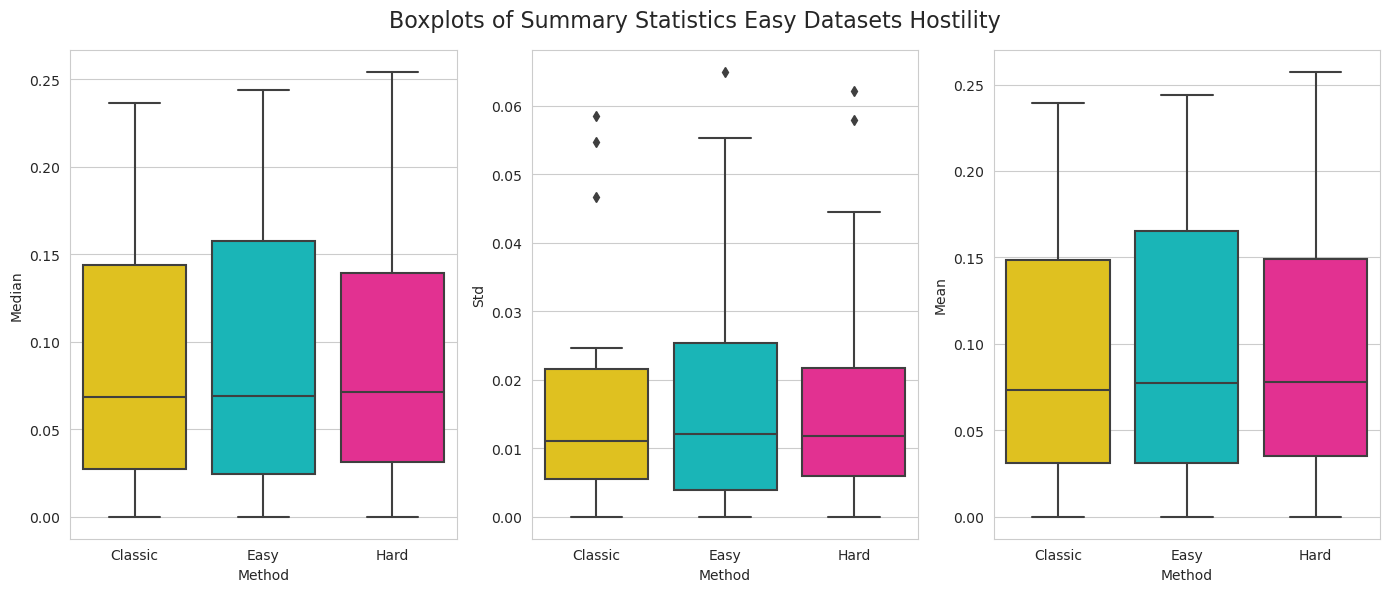

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_Hostility
0          10          (10, 2, 6)
1          25          (12, 2, 4)
2          50           (8, 2, 8)
3         100           (7, 3, 8)
4         150           (8, 4, 6)
5         200           (8, 3, 7)
6         250           (7, 6, 5)
7         300           (7, 4, 7)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_Hostility
0          10           (7, 3, 8)
1          25           (8, 3, 7)
2          50          (10, 2, 6)
3         100          (10, 2, 6)
4         150           (8, 5, 5)
5         200           (8, 5, 5)
6         250          (10, 4, 4)
7         300           (8, 5, 5)


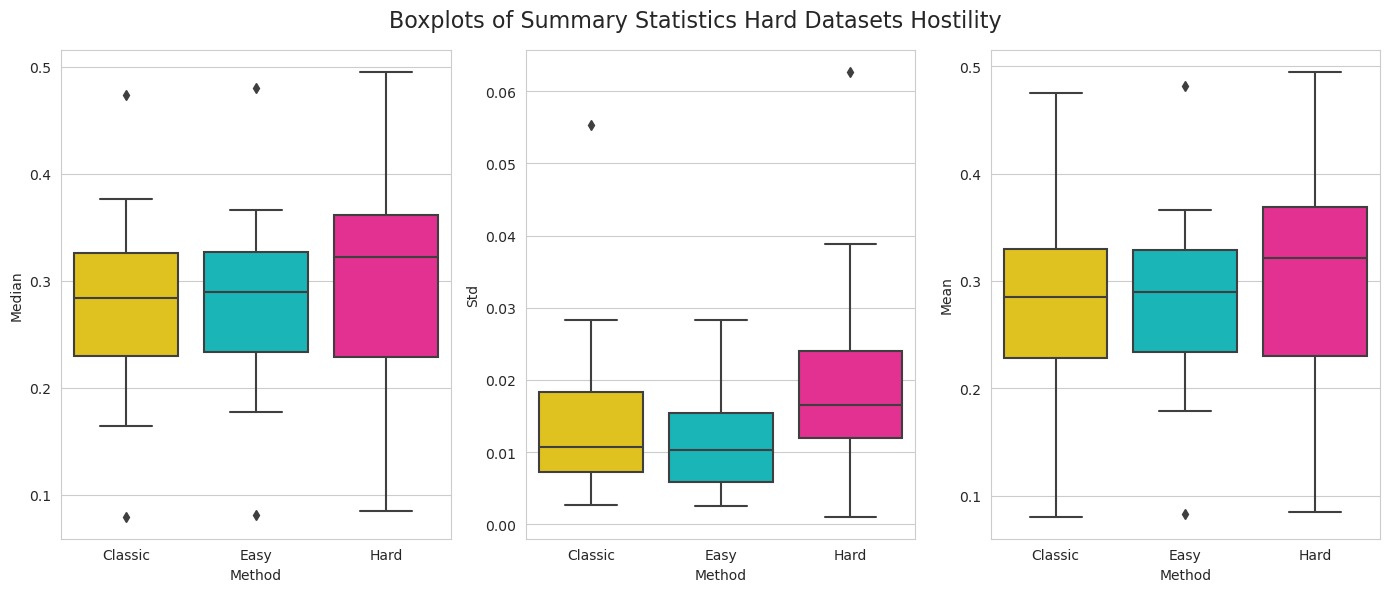

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_Hostility
0          10         (12, 1, 13)
1          25         (10, 1, 15)
2          50         (15, 0, 11)
3         100          (18, 0, 8)
4         150         (14, 1, 11)
5         200          (15, 2, 9)
6         250         (13, 0, 13)
7         300         (13, 0, 13)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_Hostility
0          10          (20, 0, 6)
1          25          (20, 0, 6)
2          50          (23, 0, 3)
3         100          (24, 0, 2)
4         150          (24, 0, 2)
5         200          (24, 0, 2)
6         250          (23, 0, 3)
7         300          (25, 0, 1)


In [11]:
CM = 'Hostility'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex, 0.2)

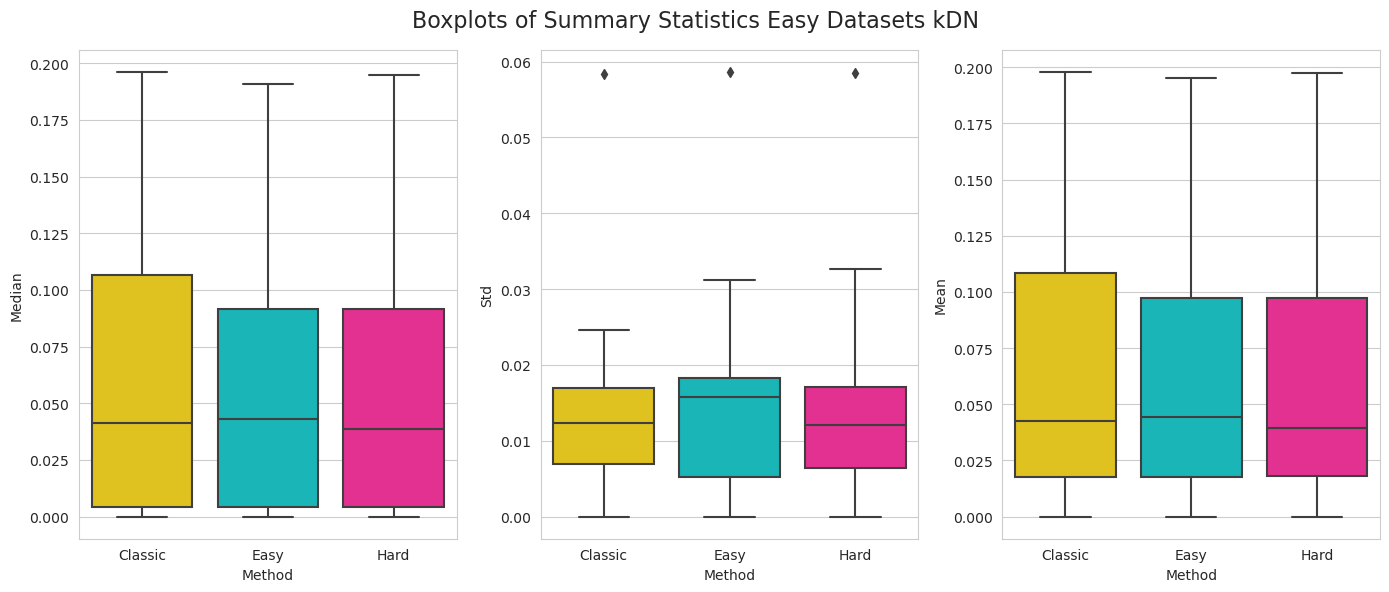

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_kDN
0          10     (6, 2, 5)
1          25     (8, 2, 3)
2          50     (6, 2, 5)
3         100     (8, 2, 3)
4         150     (5, 3, 5)
5         200     (4, 3, 6)
6         250     (5, 3, 5)
7         300     (4, 4, 5)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_kDN
0          10     (5, 3, 5)
1          25     (4, 3, 6)
2          50     (4, 2, 7)
3         100     (5, 3, 5)
4         150     (6, 4, 3)
5         200     (5, 5, 3)
6         250     (4, 5, 4)
7         300     (5, 5, 3)


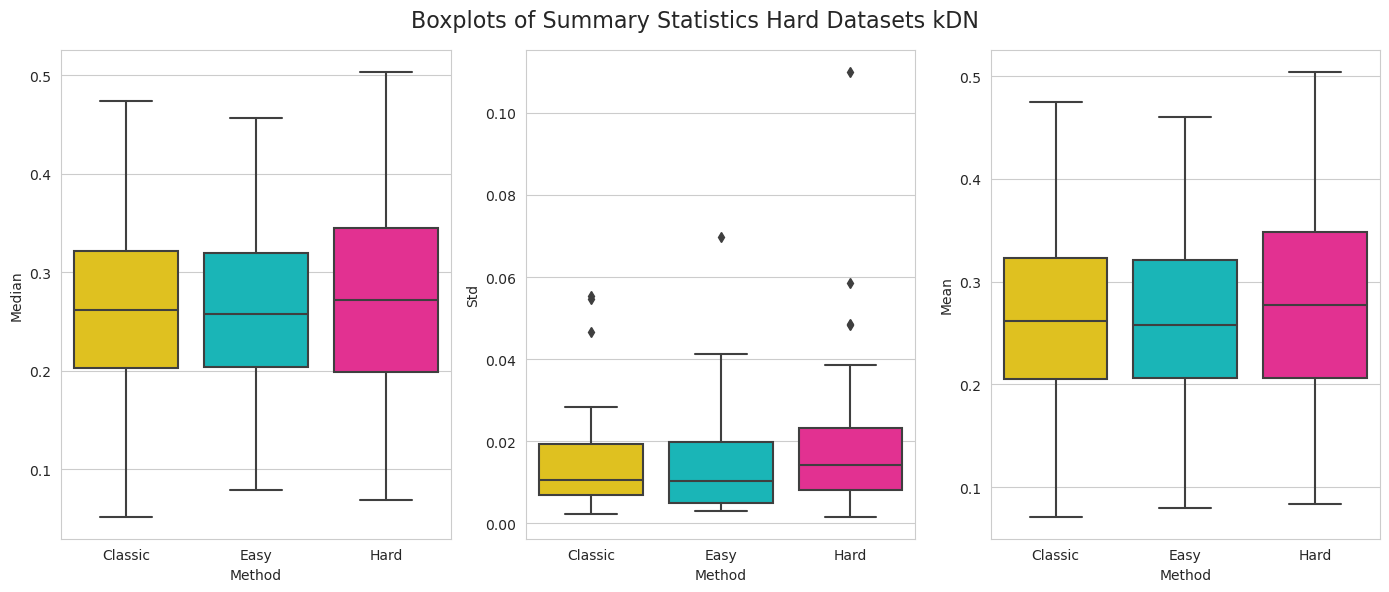

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_kDN
0          10   (14, 0, 17)
1          25   (14, 0, 17)
2          50   (15, 0, 16)
3         100   (17, 1, 13)
4         150   (15, 2, 14)
5         200   (13, 0, 18)
6         250   (16, 1, 14)
7         300   (16, 0, 15)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_kDN
0          10    (26, 0, 5)
1          25    (25, 0, 6)
2          50    (28, 0, 3)
3         100    (28, 0, 3)
4         150    (24, 0, 7)
5         200    (25, 1, 5)
6         250    (24, 0, 7)
7         300    (25, 0, 6)


In [12]:
CM = 'kDN'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex, 0.2)

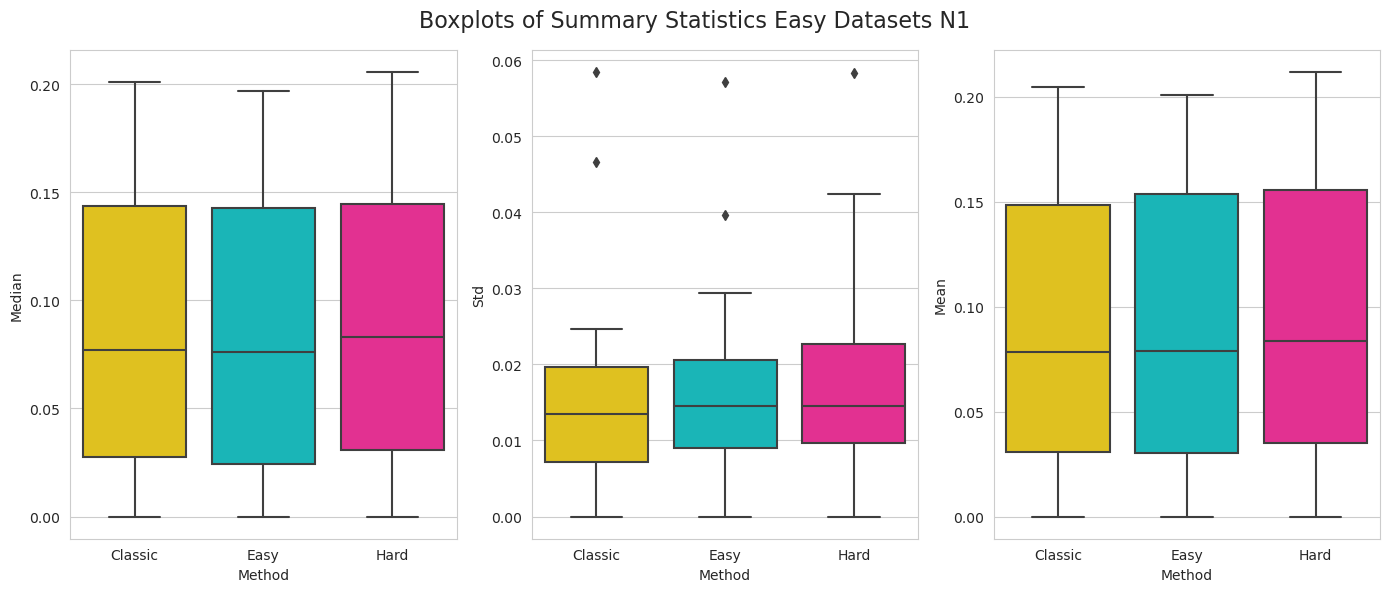

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_N1
0          10    (9, 3, 6)
1          25   (10, 2, 6)
2          50    (9, 2, 7)
3         100    (8, 3, 7)
4         150    (5, 4, 9)
5         200    (4, 5, 9)
6         250    (6, 5, 7)
7         300    (6, 4, 8)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_N1
0          10    (8, 4, 6)
1          25   (11, 3, 4)
2          50   (13, 2, 3)
3         100   (12, 4, 2)
4         150    (8, 4, 6)
5         200   (10, 4, 4)
6         250   (12, 4, 2)
7         300    (9, 4, 5)


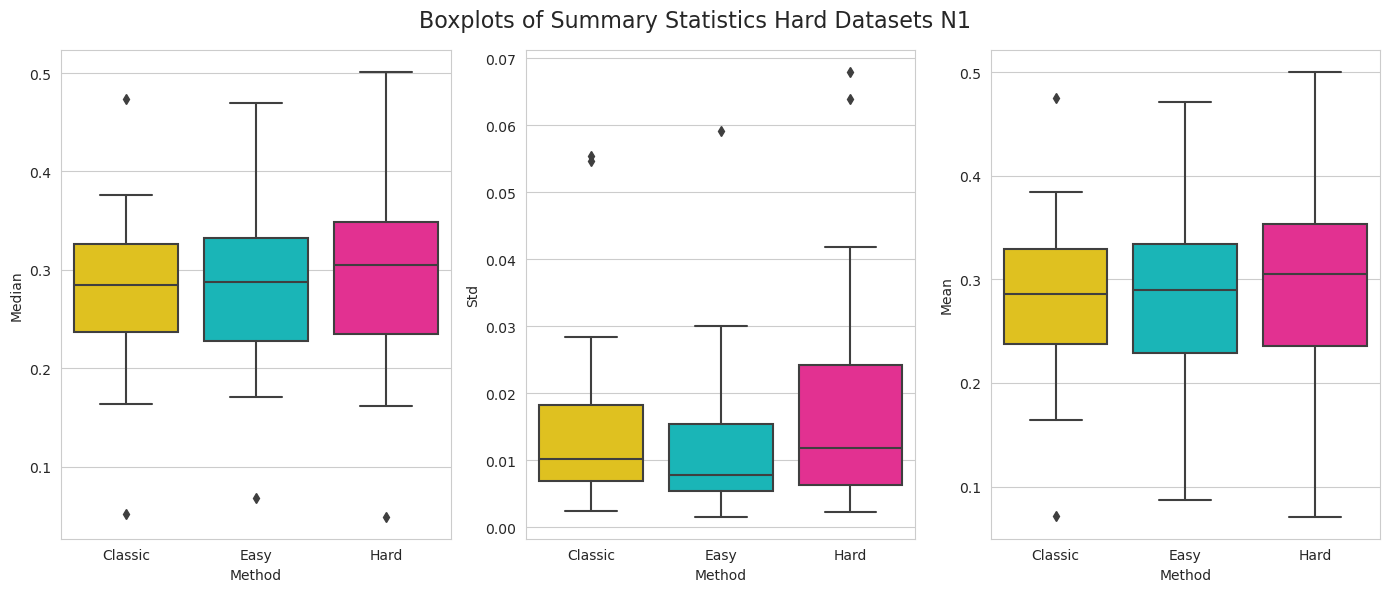

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_N1
0          10   (6, 1, 19)
1          25  (11, 2, 13)
2          50  (13, 0, 13)
3         100  (12, 1, 13)
4         150  (12, 2, 12)
5         200  (12, 1, 13)
6         250  (12, 0, 14)
7         300  (12, 0, 14)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_N1
0          10  (15, 0, 11)
1          25   (17, 0, 9)
2          50  (16, 0, 10)
3         100   (18, 0, 8)
4         150   (18, 1, 7)
5         200   (18, 1, 7)
6         250   (21, 0, 5)
7         300   (19, 0, 7)


In [13]:
CM = 'N1'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.25)

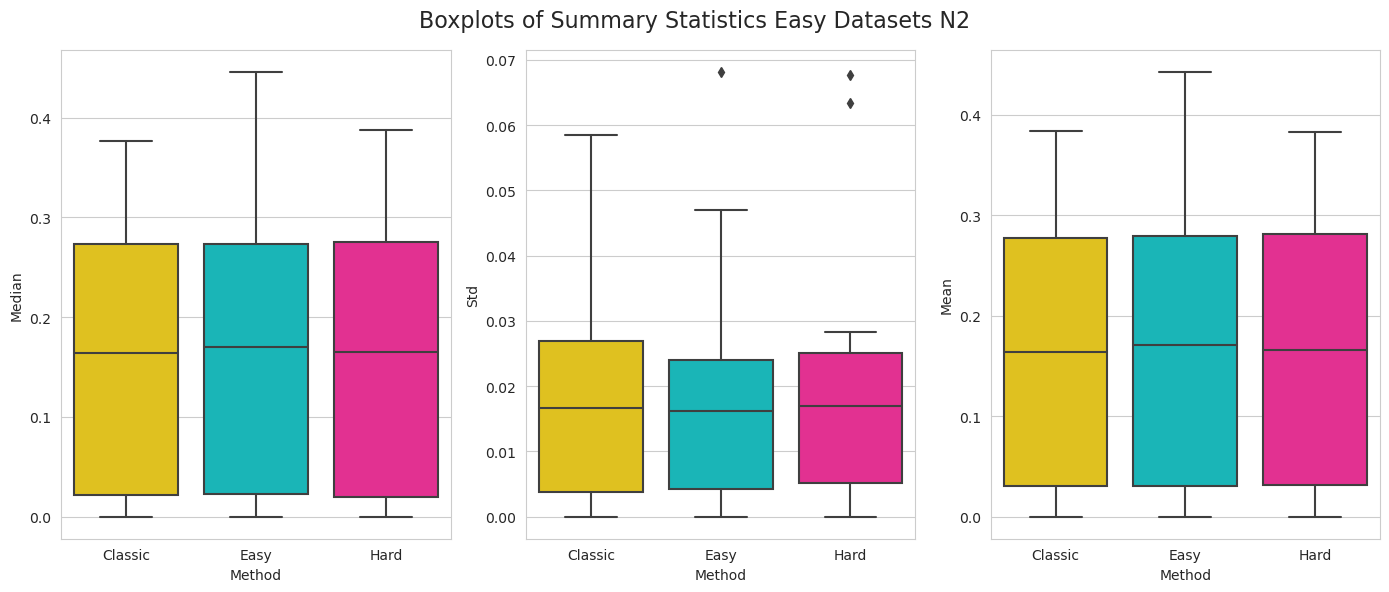

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_N2
0          10    (8, 1, 2)
1          25    (5, 1, 5)
2          50    (7, 1, 3)
3         100    (4, 3, 4)
4         150    (7, 2, 2)
5         200    (8, 2, 1)
6         250    (7, 3, 1)
7         300    (5, 3, 3)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_N2
0          10    (4, 2, 5)
1          25    (6, 2, 3)
2          50    (6, 2, 3)
3         100    (3, 3, 5)
4         150    (4, 2, 5)
5         200    (4, 3, 4)
6         250    (6, 2, 3)
7         300    (6, 3, 2)


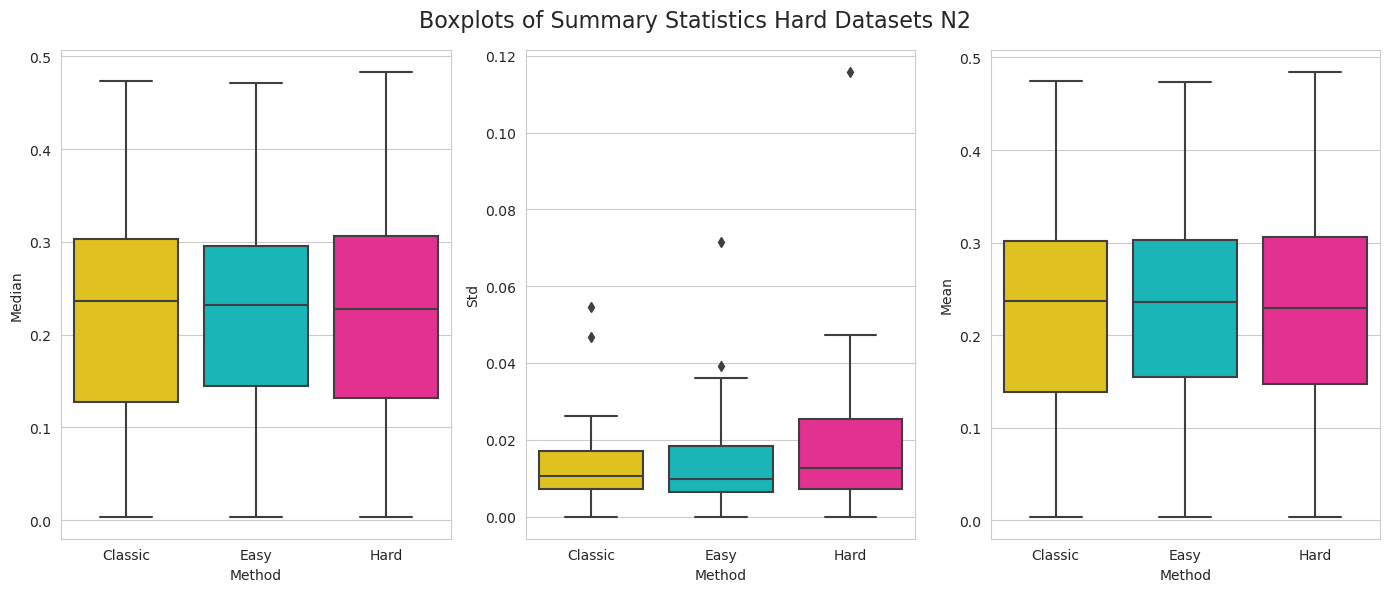

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_N2
0          10  (13, 1, 19)
1          25  (18, 1, 14)
2          50  (17, 2, 14)
3         100  (19, 1, 13)
4         150  (14, 1, 18)
5         200  (11, 2, 20)
6         250  (18, 1, 14)
7         300  (18, 2, 13)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_N2
0          10  (22, 1, 10)
1          25  (21, 2, 10)
2          50   (25, 1, 7)
3         100  (20, 1, 12)
4         150  (17, 3, 13)
5         200  (18, 3, 12)
6         250  (21, 2, 10)
7         300  (18, 1, 14)


In [14]:
CM = 'N2'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.3)

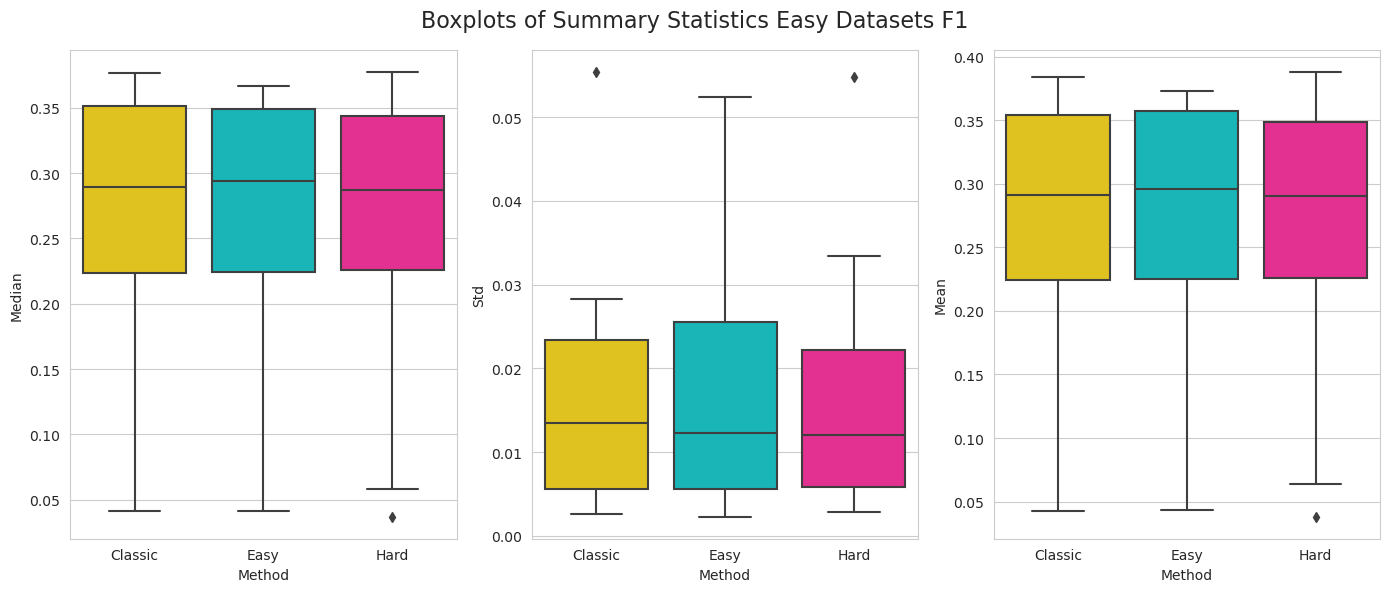

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_F1
0          10    (8, 0, 2)
1          25    (5, 0, 5)
2          50    (7, 0, 3)
3         100    (6, 1, 3)
4         150    (6, 1, 3)
5         200    (8, 0, 2)
6         250    (5, 0, 5)
7         300    (5, 1, 4)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_F1
0          10    (7, 0, 3)
1          25    (3, 0, 7)
2          50    (6, 0, 4)
3         100    (4, 0, 6)
4         150    (0, 1, 9)
5         200    (4, 0, 6)
6         250    (5, 0, 5)
7         300    (5, 0, 5)


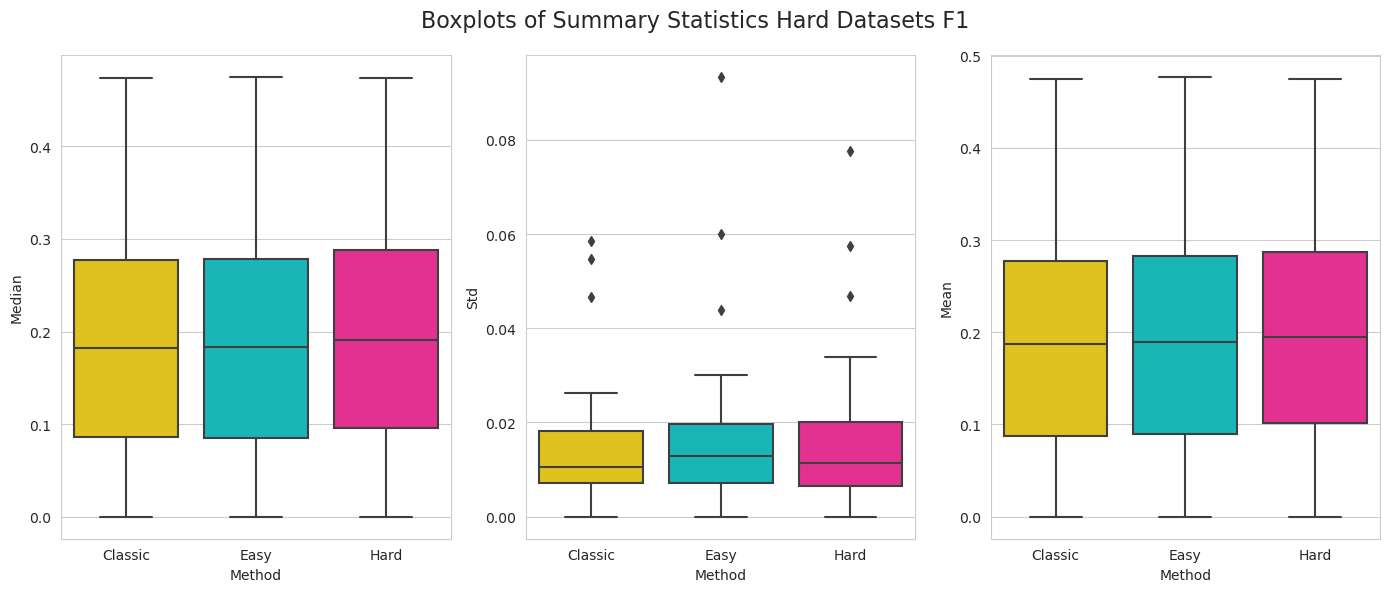

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_F1
0          10  (17, 3, 14)
1          25  (20, 3, 11)
2          50  (21, 3, 10)
3         100   (24, 3, 7)
4         150  (20, 4, 10)
5         200  (16, 5, 13)
6         250  (16, 6, 12)
7         300  (17, 4, 13)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_F1
0          10  (14, 3, 17)
1          25  (18, 2, 14)
2          50  (19, 3, 12)
3         100  (17, 4, 13)
4         150  (18, 4, 12)
5         200  (15, 6, 13)
6         250  (19, 4, 11)
7         300  (19, 4, 11)


In [15]:
CM = 'F1'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.5)

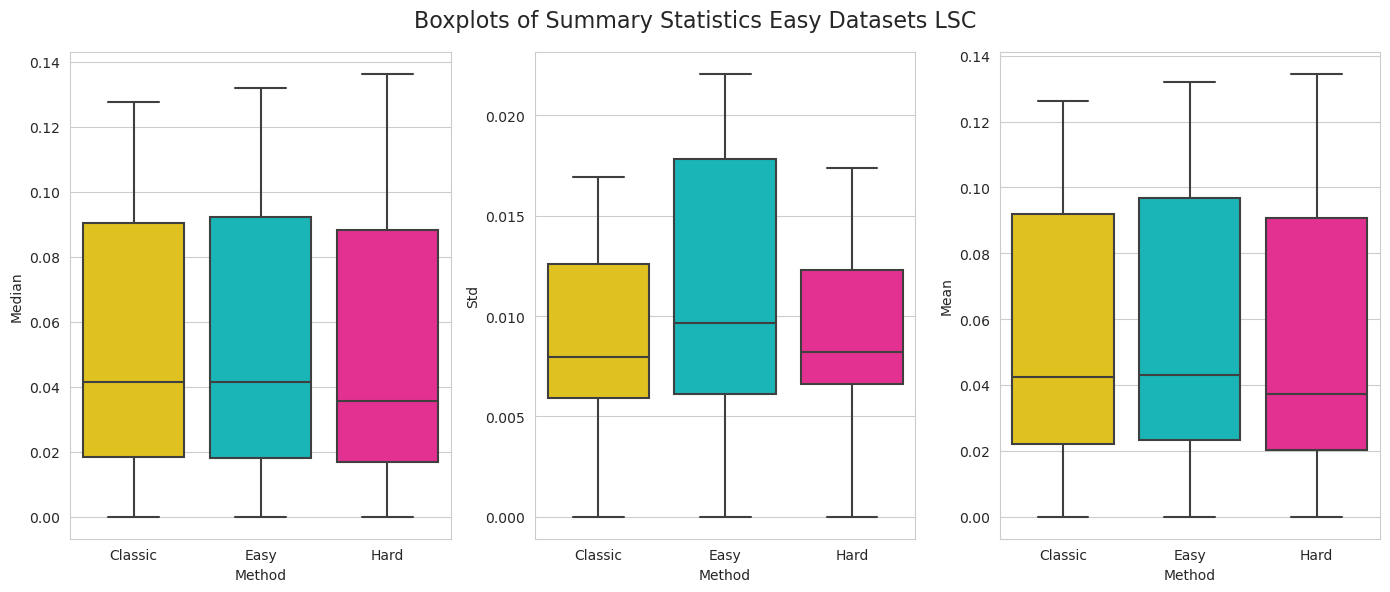

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_LSC
0          10     (6, 1, 0)
1          25     (6, 1, 0)
2          50     (5, 1, 1)
3         100     (5, 1, 1)
4         150     (5, 1, 1)
5         200     (2, 2, 3)
6         250     (1, 2, 4)
7         300     (3, 2, 2)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_LSC
0          10     (3, 1, 3)
1          25     (3, 1, 3)
2          50     (2, 1, 4)
3         100     (3, 2, 2)
4         150     (1, 3, 3)
5         200     (2, 1, 4)
6         250     (2, 2, 3)
7         300     (2, 2, 3)


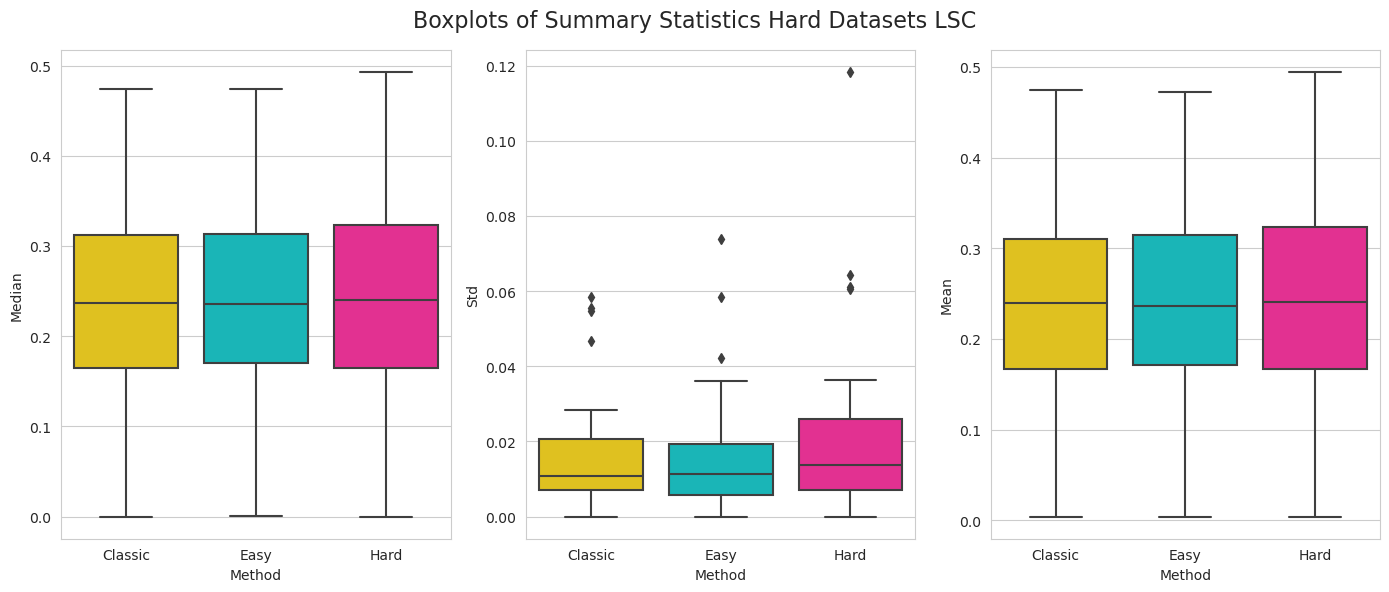

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_LSC
0          10   (13, 2, 22)
1          25   (18, 2, 17)
2          50   (19, 1, 17)
3         100   (22, 1, 14)
4         150   (18, 2, 17)
5         200   (19, 5, 13)
6         250   (20, 2, 15)
7         300   (16, 3, 18)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_LSC
0          10   (25, 1, 11)
1          25   (24, 1, 12)
2          50   (25, 2, 10)
3         100    (27, 2, 8)
4         150   (21, 3, 13)
5         200    (26, 2, 9)
6         250   (25, 2, 10)
7         300   (22, 3, 12)


In [16]:
CM = 'LSC'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.9)

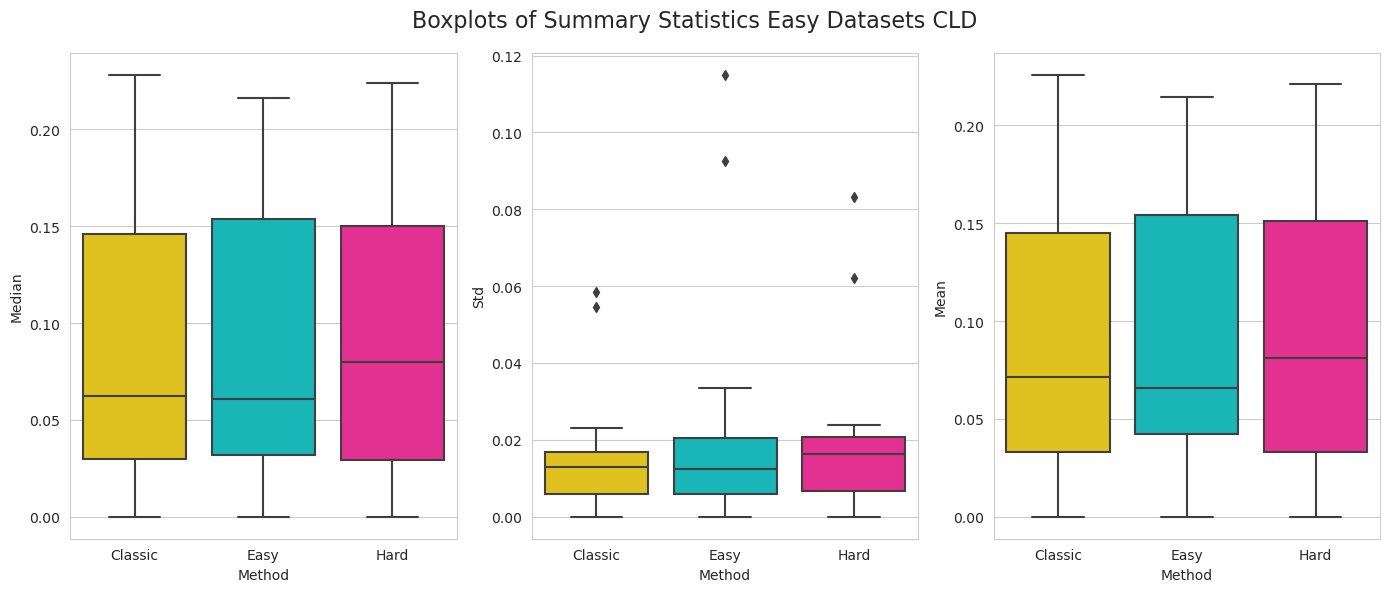

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_CLD
0          10    (10, 1, 4)
1          25    (11, 1, 3)
2          50     (9, 1, 5)
3         100    (10, 2, 3)
4         150     (8, 2, 5)
5         200     (7, 2, 6)
6         250    (10, 2, 3)
7         300     (9, 2, 4)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_CLD
0          10    (10, 2, 3)
1          25     (7, 1, 7)
2          50     (9, 1, 5)
3         100     (9, 2, 4)
4         150     (7, 3, 5)
5         200     (8, 2, 5)
6         250     (9, 3, 3)
7         300     (9, 3, 3)


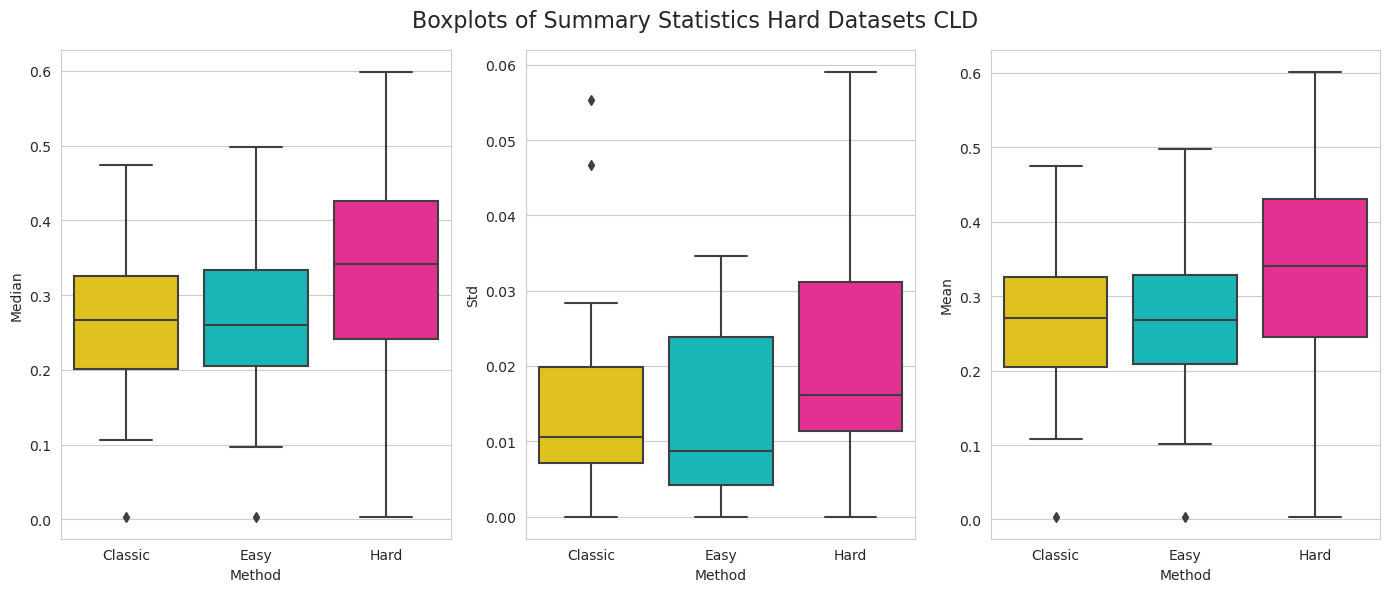

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_CLD
0          10   (15, 1, 13)
1          25   (18, 1, 10)
2          50   (18, 1, 10)
3         100   (16, 1, 12)
4         150   (15, 1, 13)
5         200   (17, 1, 11)
6         250   (18, 1, 10)
7         300   (17, 1, 11)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_CLD
0          10    (25, 1, 3)
1          25    (25, 2, 2)
2          50    (27, 1, 1)
3         100    (24, 2, 3)
4         150    (25, 1, 3)
5         200    (24, 1, 4)
6         250    (24, 1, 4)
7         300    (23, 1, 5)


In [17]:
CM = 'CLD'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.3)

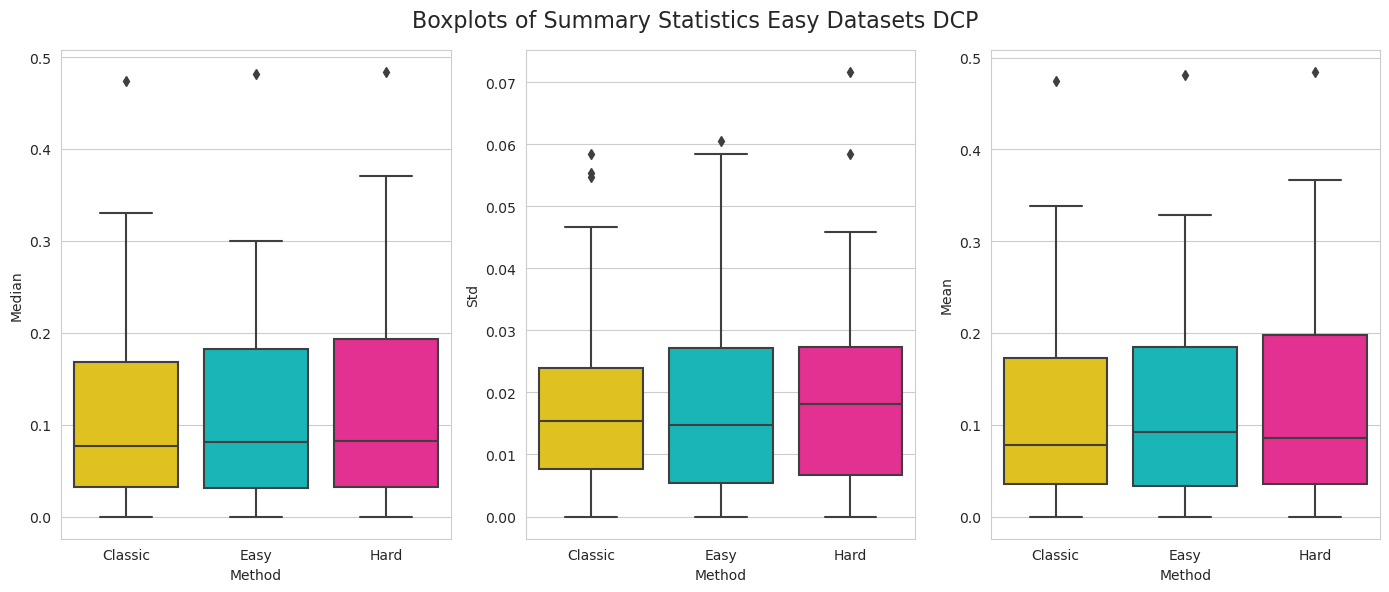

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_DCP
0          10    (14, 3, 3)
1          25    (12, 3, 5)
2          50    (13, 3, 4)
3         100    (12, 3, 5)
4         150    (11, 3, 6)
5         200    (13, 4, 3)
6         250    (12, 4, 4)
7         300    (10, 5, 5)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_DCP
0          10    (12, 3, 5)
1          25    (13, 3, 4)
2          50    (14, 4, 2)
3         100    (10, 4, 6)
4         150    (11, 5, 4)
5         200    (12, 4, 4)
6         250    (14, 4, 2)
7         300    (15, 4, 1)


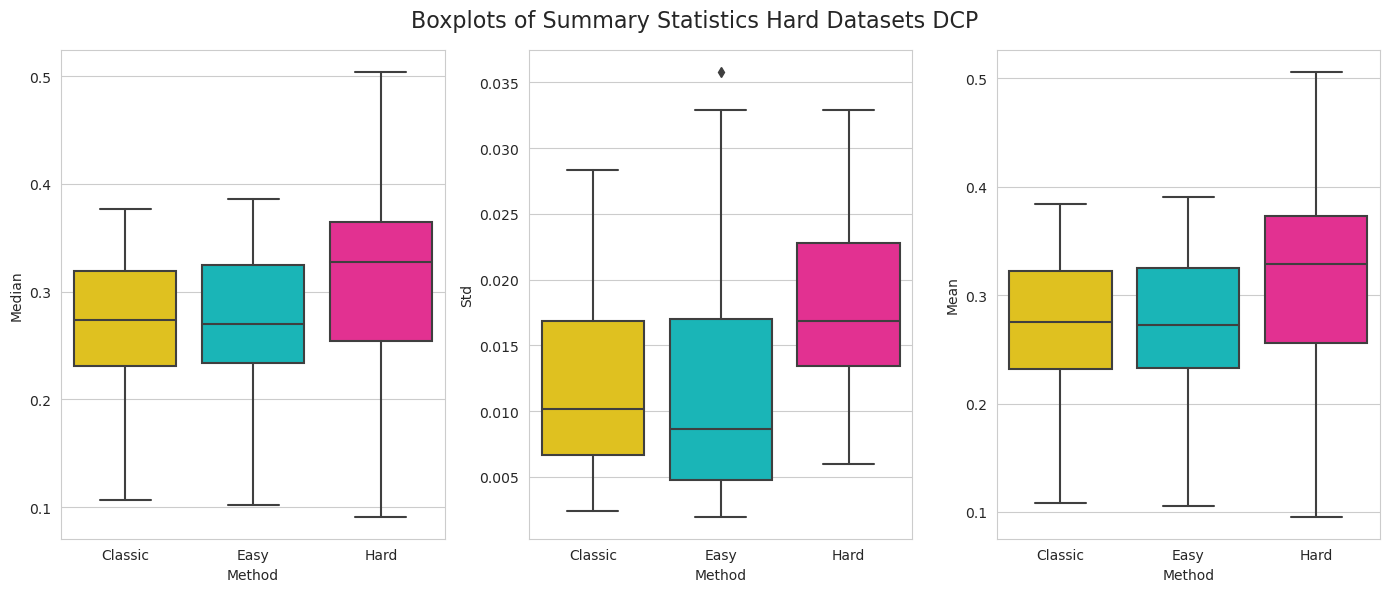

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_DCP
0          10   (13, 0, 11)
1          25   (13, 1, 10)
2          50   (14, 0, 10)
3         100    (15, 1, 8)
4         150    (14, 1, 9)
5         200   (10, 3, 11)
6         250    (9, 0, 15)
7         300   (10, 1, 13)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_DCP
0          10    (20, 0, 4)
1          25    (22, 0, 2)
2          50    (21, 0, 3)
3         100    (20, 0, 4)
4         150    (22, 0, 2)
5         200    (20, 0, 4)
6         250    (19, 0, 5)
7         300    (20, 1, 3)


In [18]:
CM = 'DCP'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.2)

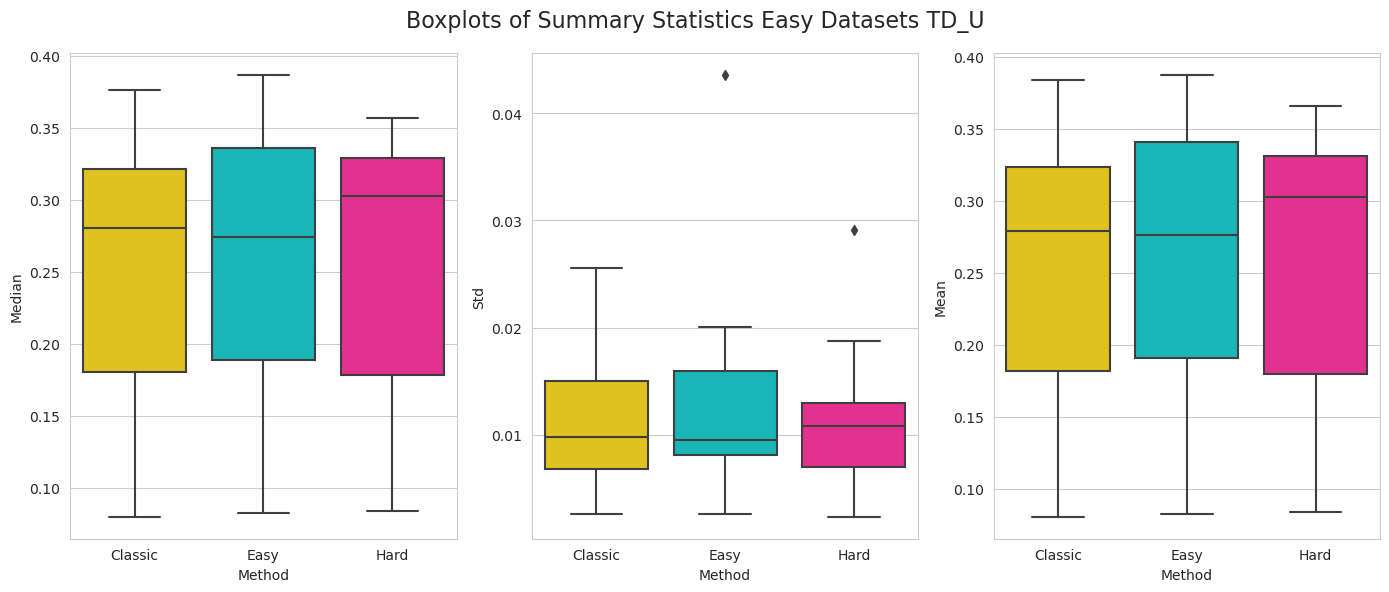

Easy datasets: WTL Classic vs init_easy
   n_ensemble init_easy_TD_U
0          10      (6, 0, 5)
1          25      (7, 0, 4)
2          50      (8, 0, 3)
3         100      (9, 0, 2)
4         150      (7, 1, 3)
5         200      (6, 1, 4)
6         250      (7, 0, 4)
7         300      (6, 0, 5)
Easy datasets: WTL Classic vs init_hard
   n_ensemble init_hard_TD_U
0          10      (7, 1, 3)
1          25     (10, 0, 1)
2          50      (9, 0, 2)
3         100     (10, 0, 1)
4         150      (9, 0, 2)
5         200      (7, 0, 4)
6         250      (4, 0, 7)
7         300      (6, 0, 5)


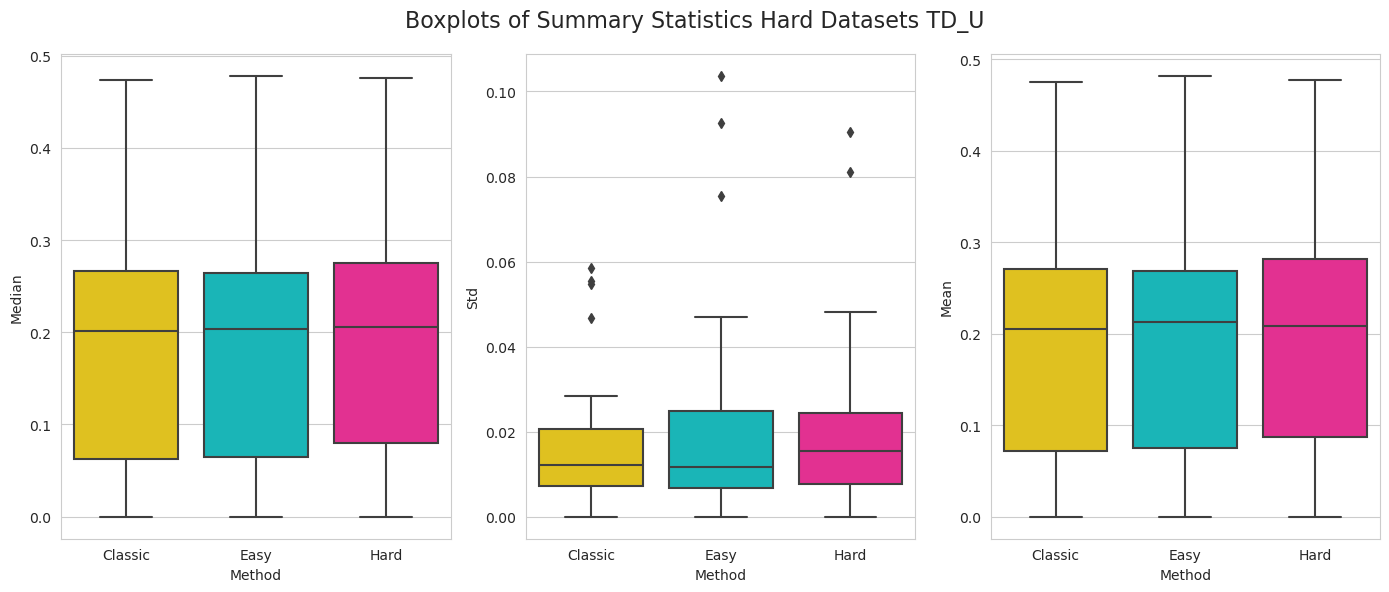

Hard datasets: WTL Classic vs init_easy
   n_ensemble init_easy_TD_U
0          10    (20, 2, 11)
1          25    (19, 3, 11)
2          50    (18, 3, 12)
3         100    (19, 3, 11)
4         150    (17, 3, 13)
5         200     (22, 3, 8)
6         250    (15, 4, 14)
7         300    (14, 5, 14)
Hard datasets: WTL Classic vs init_hard
   n_ensemble init_hard_TD_U
0          10     (25, 3, 5)
1          25     (24, 3, 6)
2          50     (24, 2, 7)
3         100     (25, 4, 4)
4         150     (20, 6, 7)
5         200    (19, 4, 10)
6         250     (22, 5, 6)
7         300     (22, 4, 7)


In [19]:
CM = 'TD_U'
summary_pivot_easy, summary_pivot_hard, result_table_init_easy_easy, result_table_init_easy_hard,result_table_init_hard_easy,result_table_init_hard_hard = summary_CM_complexity_dataset(CM,all_datasets,df_complex,0.5)

Ahora vamos a estudiar qué complejidades tienen los datasets para los que nuestro método pierde, empata o gana y esto lo haremos para cada una de las medidas de complejidad

In [20]:
def win_tie_loss_comparison_info_complexity(data, complexity_df, main_method, compare_method, metric='misc_rate_test_mean',n_ensemble_values=[10, 25, 50, 100, 150, 200, 250, 300]):
    """
    Realiza un análisis win-tie-loss comparando el método principal con otro método específico para cada medida de complejidad.

    Parameters:
    - data: DataFrame con las columnas ['dataset', 'n_ensemble', 'method_weights', 'compl_measure', metric]
    - main_method: método principal que se desea comparar (ejemplo: 'classic')
    - compare_method: método específico con el cual comparar el principal (ejemplo: 'init_easy')
    - metric: métrica de comparación (por defecto 'misc_rate_test_mean')
    - n_ensemble_values: valores de n_ensemble a considerar

    Returns:
    - Una tabla con el conteo de wins, ties, y losses por cada valor de n_ensemble y medida de complejidad.
    """
    results = []
    # Crear una lista para almacenar los resultados
    all_results = []
    value_wtl = 'nada'

    for n in n_ensemble_values:
        # Filtrar los datos para el valor actual de n_ensemble
        subset_n = data[data['n_ensemble'] == n]


        # Crear un diccionario para almacenar los resultados de esta combinación de n_ensemble
        row = {'n_ensemble': n}

        CM_list = subset_n['compl_measure'].unique()[1:] # to delete none

        for compl in CM_list:
            win, tie, loss = 0, 0, 0

            # Filtrar los datos para la medida de complejidad actual
            subset_compl = subset_n[subset_n['compl_measure'] == compl]
            #if (main_method == 'classic') or (compare_method == 'classic'):
            #     subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']

            for dataset in subset_compl['dataset'].unique():
                # Filtrar para el dataset y métod en cuestión

                if (main_method == 'classic'):
                    subset_compl_main = subset_n[subset_n['compl_measure'] == 'none']
                    main_value = subset_compl_main[(subset_compl_main['dataset'] == dataset) & (subset_compl_main['method_weights'] == main_method)][metric].values
                else:
                    main_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == main_method)][metric].values
                if (compare_method == 'classic'):
                    subset_compl_compare = subset_n[subset_n['compl_measure'] == 'none']
                    compare_value = subset_compl_compare[(subset_compl_compare['dataset'] == dataset) & (subset_compl_compare['method_weights'] == compare_method)][metric].values
                else:
                    compare_value = subset_compl[(subset_compl['dataset'] == dataset) & (subset_compl['method_weights'] == compare_method)][metric].values

                # Verificar que tenemos valores únicos para cada dataset y métod
                if main_value.size > 0 and compare_value.size > 0:
                    main_value = main_value[0]
                    compare_value = compare_value[0]

                    # Comparación win-tie-loss
                    if main_value < compare_value:
                        win += 1
                        value_wtl = 'win'
                    elif main_value == compare_value:
                        tie += 1
                        value_wtl = 'tie'
                    else:
                        loss += 1
                        value_wtl = 'loss'

                # Obtener las medidas de complejidad para el dataset
                complexity_values = complexity_df[complexity_df['dataset'] == dataset][compl].values
                if complexity_values.size > 0:
                    complexity_value = complexity_values[0]

                    # Almacenar los resultados en una lista de diccionarios
                    all_results.append({
                        'n_ensemble': n,
                        'compl_measure': compl,
                        'result': value_wtl,
                        'complexity_value': complexity_value
                    })

            # Guardar el resultado para esta medida de complejidad en una columna específica
            row[f'{compare_method}_{compl}'] = (win, tie, loss)

        # Agregar el resultado de esta iteración a los resultados
        results.append(row)

    # Convertir los resultados a DataFrame
    win_tie_loss_df = pd.DataFrame(results)

    return win_tie_loss_df, all_results